In [1]:
# imports
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import os
import glob
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator


In [2]:
# get directories
main_direc = os.getcwd()
images_dir = os.path.join(main_direc, 'data/images/images')

# csv location
artist_csv_loc = os.path.join(main_direc, 'data/artists.csv')

## Loading Data
The below section loads in the data, making necessary preprocess changes.
Generators are used to augment the data.

### Hyperparameter Section for data preprocessing
The following code block allows you to set different hyperparams for loading in
the images.

In [3]:
"""
Set hyperparams for the number of classes and image generators
"""

IMG_WIDTH = 299
IMG_HEIGHT = 299
BATCH_SIZE = 64
NUM_ARTISTS = 10 # this is 11 to get to 10 classes, can be changed...

### DataFrame management
The following code block loads the artists csv into pandas dataframe, sorts by
number of paintings, and makes a dataframe with the top 10 artists by painting
count, to give us the most amount of data possible.

In [4]:
# Collecting Needed Images
artists = pd.read_csv(artist_csv_loc)

# Creating a dataframe with the top 10 artists by number of paintings
artists_sort = artists.sort_values(by=['paintings'], ascending=False)

# add one to reach the first 10 classes
artists_top = artists_sort.head(NUM_ARTISTS + 1)

# Images
artists_dir = os.listdir(images_dir) # Files are named after each artists

# Images DataFrame
artists_top_name = artists_top['name'].str.replace(' ', '_').values

images_df = pd.DataFrame()
for name in artists_top_name:
    images_df = pd.concat([images_df, pd.DataFrame(data={'Path': glob.glob('data/images/images/' + name + '/*'), 'Name': name})], ignore_index=True)

train_df = images_df.sample(frac=0.8, random_state=200)
test_df = images_df.drop(train_df.index)

if K.backend.image_data_format() == 'channels_first':
    input_shape = (3, IMG_HEIGHT, IMG_WIDTH)
else:
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

    id                   name        years                         genre  \
8    8       Vincent van Gogh  1853 – 1890            Post-Impressionism   
30  30            Edgar Degas  1834 - 1917                 Impressionism   
13  13          Pablo Picasso  1881 - 1973                        Cubism   
15  15  Pierre-Auguste Renoir  1841 - 1919                 Impressionism   
19  19         Albrecht Dürer  1471 - 1528          Northern Renaissance   
46  46           Paul Gauguin  1848 – 1903  Symbolism,Post-Impressionism   
16  16         Francisco Goya  1746 - 1828                   Romanticism   
31  31              Rembrandt  1606 - 1669                       Baroque   
20  20          Alfred Sisley  1839 - 1899                 Impressionism   
32  32                 Titian  1488 - 1576    High Renaissance,Mannerism   
22  22           Marc Chagall  1887 - 1985                   Primitivism   

                 nationality  \
8                      Dutch   
30                    F

### Building generators
The next code block builds generators for augmenting the data.

In [5]:
"""
Build generators
"""

train_generator = ImageDataGenerator(rescale=1.0 / 255,
                                    rotation_range=20,
                                    zoom_range=0.05,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    horizontal_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.15,
                                    preprocessing_function=preprocess_input
                                    )

test_generator = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)

train_gen = train_generator.flow_from_dataframe(
    train_df,
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    subset="training",
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=42
)

valid_gen = train_generator.flow_from_dataframe(
    train_df,
    subset="validation",
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=42
)

test_gen = test_generator.flow_from_dataframe(
    test_df,
    x_col='Path',
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

# Set the amount of steps for training, validation, and testing data
# based on the batch size
steps_train = train_gen.n//train_gen.batch_size
steps_valid = valid_gen.n//valid_gen.batch_size
steps_test = test_gen.n//test_gen.batch_size

Found 2328 validated image filenames belonging to 10 classes.
Found 410 validated image filenames belonging to 10 classes.
Found 684 validated image filenames.


## Clay's Model
The following model was designed by Clay Kaufmann. It uses Inception V3 as a
base line, and makes modifications from there.

### Hyperparameter Block
Set different hyperparameters for the model with the following block.

In [6]:
"""
Hyperparameters here:
"""

N_EPOCHS = 10
LEARNING_RATE = 0.001 # 0.001 is the default for Adam set by TensorFlow
OPTIMIZER = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FUNCTION = tf.losses.CategoricalCrossentropy(from_logits=False)

In [7]:
"""
Build the model
"""

# set the input for VGG
inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))

# load model
base_model = InceptionV3(include_top=False, input_tensor=inp, pooling='max', weights='imagenet')

# set base model to not be trainable
base_model.trainable = False

# create sequential model
final_model = tf.keras.Sequential()

# add the base model in
final_model.add(base_model)

final_model.add(K.layers.Flatten())
final_model.add(K.layers.BatchNormalization())
final_model.add(Dense(256, activation='relu'))
final_model.add(K.layers.Dropout(0.6))

# this needed to be the number of artists - 1
final_model.add(Dense(NUM_ARTISTS, activation='softmax'))

final_model.summary()

# compile model
final_model.compile(
  optimizer=OPTIMIZER,
  loss=LOSS_FUNCTION,
  metrics=['accuracy']
)

2021-12-15 23:09:45.595251: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 22,338,090
Trainable params: 531,210
Non-trainable params: 21,806,880
______________________________________

In [ ]:
"""
Train the model
"""

# create a checkpoint for the model
checkpt = ModelCheckpoint(filepath='clay_trained_model.hdf5', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Fit the model
final_model.fit_generator(
    generator = train_gen,
    steps_per_epoch=steps_train,
    validation_data = valid_gen,
    validation_steps = steps_valid,
    verbose=1,
    epochs=N_EPOCHS,
    callbacks=[checkpt, early_stop]
)

### Metrics Section
In the following codeblocks, metrics are used and plots are created to show how
the model performed.  
A confusion matrix is creating, using Seaborn's heatmap feature. A
classification report from sklearn metrics is also run.

In [8]:
"""
Make predictions
"""

# Load model weights
final_model.load_weights('clay_trained_model.hdf5')

# make predictions using the test set
predict = final_model.predict_generator(test_gen, steps=steps_test, verbose=1)

# collect the actual index of the predicted class
predicted_class = np.argmax(predict, axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2021-12-15 23:09:49.319087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


684/684 [==============================] - 63s 92ms/step


              precision    recall  f1-score   support

           0       0.89      0.86      0.87        64
           1       0.87      0.82      0.84        55
           2       0.73      0.74      0.73       121
           3       0.81      0.77      0.79        65
           4       0.93      0.55      0.69        47
           5       0.63      0.89      0.74        97
           6       0.77      0.79      0.78        63
           7       0.75      0.76      0.76        76
           8       0.86      0.77      0.81        48
           9       0.91      0.65      0.76        48

    accuracy                           0.77       684
   macro avg       0.81      0.76      0.78       684
weighted avg       0.79      0.77      0.77       684



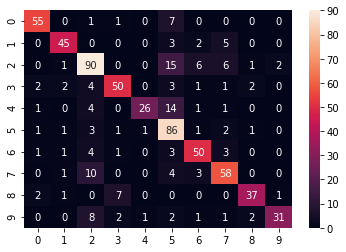

In [9]:
"""
Produce result metrics
"""

# collect the actual classes of the predictions
r = dict(train_gen.class_indices.items())
y_true = test_df['Name']
y_true = [r[k] for k in y_true]

# create confusion matrix
cm = confusion_matrix(y_true, predicted_class)
sns.heatmap(cm, annot=True)

# print classification report
print(classification_report(y_true, predicted_class))